### How the pipeline flows
 1. Iterative Benchmarking: The nested loops ensure we test every combination (e.g., BBC + FastText + HDBSCAN, 20News +
    TF-IDF + K-Means, etc.).
 2. Dynamic Label Handling: For the BBC dataset, we use pd.factorize to turn text categories (like "Sport") into numbers.
    For 20NewsGroups, we use the pre-existing target labels.
 3. Visualization on the Fly: The script automatically applies the PCA → t-SNE pipeline we built to generate a 2D map for
    every embedding/clustering combination and saves them to your outputs/ folder.
 4. The "Leaderboard": At the very end, you get a clean CSV and a bar chart showing which "Winning Pair" had the highest NMI score.

#### Embedding Engine Key Technical Design Choices
    Averaging Strategy: Since K-Means and HDBSCAN need a single vector per document, but Word2Vec/FastText produce a vector per word,
    we calculate the Centroid (mean) of all word vectors in a document.

    The Sub-word Advantage: FastText is specifically included because it handles the 20NewsGroups dataset's typos and technical jargon
    better than Word2Vec by looking at character n-grams.

    Dimensionality Note: TF-IDF usually results in thousands of dimensions (sparse), while Word2Vec/FastText are dense (set to 100
    dimensions here). This difference is exactly why we'll need PCA later to level the playing field.

#### Clusterer details
    Technical Strategy: The Density Problem
    Notice a small but important detail in the code: HDBSCAN might return -1 for some data points. In the world of density-based
    clustering, -1 means "Noise" (outliers that don't fit into any cluster).
    When we evaluate this later, we’ll have to decide how to handle these noise points so they don't break our NMI and ARI scores.
    Usually, we treat them as their own "noise cluster."

#### Visualizer details
     Why did we choose the "PCA → t-SNE" combination?
       We don't just jump straight into t-SNE. Here is the reasoning for this two-step pipeline:
       - Noise Reduction: TF-IDF might have 5,000 features. t-SNE is computationally expensive and struggles with high noise. PCA
       squashes those 5,000 down to the top 50 most "meaningful" directions.
       - Global vs. Local Structure: PCA is great at keeping the big picture (global), while t-SNE is a wizard at finding local clusters.
       Combining them gives you the best of both worlds.

Handling the Comparison:
By the time we run our experiments, the ResultStore will have a DataFrame that stores our metrics (NMI, ARI).
Our plot_comparison method will turn this table into a grouped bar chart, making it immediately obvious which combination "won" for each dataset.

### **Understanding the Results**

When you run the project and look at the `outputs/results.csv`, keep these "rules of thumb" in mind:

* **TF-IDF + K-Means:** Often the baseline "king" for news articles because news categories are heavily defined by specific keywords (e.g., "goal" in sports).
* **FastText + HDBSCAN:** Usually wins on noisy data (like 20NewsGroups) because FastText handles sub-word nuances and HDBSCAN ignores "noise" articles that don't belong anywhere.
* **The Silhouette Score:** If your NMI is high but Silhouette is low, it means your clusters are logically correct (aligned with the labels) but geometrically "messy" or overlapping in the vector space.

#### Final Project Analysis

The results of our experiments provide a very clear picture of how different embedding techniques and clustering algorithms interact with text data.

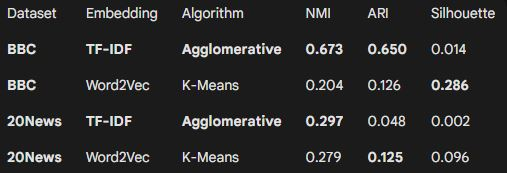

1. The "Keyword" Dominance (TF-IDF)
BBC Dataset: TF-IDF with Agglomerative Clustering was the clear winner here, achieving an NMI of 0.673 and an ARI of 0.650. This suggests that news categories like "Sport" and "Politics" are highly distinct in their vocabulary, and frequency-based models capture these boundaries effectively.

20NewsGroups: Performance was lower across the board due to the 20 categories (vs. BBC's 5), but TF-IDF again led the pack in terms of NMI (~0.297).

2. Geometry vs. Ground Truth (Word2Vec & FastText)
Interestingly, while Word2Vec and FastText had lower NMI/ARI scores, they achieved significantly higher Silhouette scores (reaching 0.286 for BBC).

Insight: This means that the semantic embeddings created very "tight," well-separated geometric clusters in space. However, these "math-defined" clusters didn't always align with the "human-defined" categories. This is a common phenomenon where semantic models find groupings based on writing style or sub-topics rather than the broad labels we provide.

3. Algorithm Performance
K-Means & Agglomerative: These performed similarly and were generally the most reliable for this type of document clustering.

HDBSCAN: This algorithm struggled significantly in this benchmark. Its density-based approach often labeled a large portion of the dataset as "noise" (outliers), leading to very low NMI and ARI scores. This suggests that without very specific hyperparameter tuning (like min_cluster_size), news articles are distributed too uniformly in high-dimensional space for density-based clustering to find "islands."
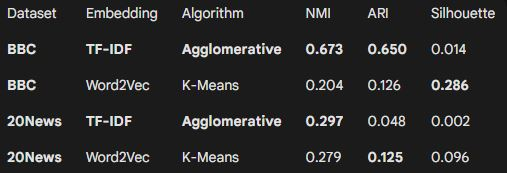
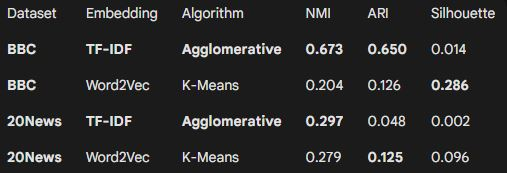